In [2]:
%matplotlib inline
import sys
sys.path.append('..')

import pickle
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from assimilation import OI, ExtendedKF, EnKF, M3DVar

In [13]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

In [18]:
dt = 0.01

In [19]:
# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

In [23]:
def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# Assimilate normal observation

#### `rmse_enkf` as CNTL in the later experiments

In [35]:
# normal observation
X_obs = np.load('./data/obs_normal.npy')

In [36]:
enkf = EnKF(lorenz63_fdm, dt)
enkf.list_params()
params = {
    'X_ens_ini': X_ens_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.4
}
enkf.set_params(**params)
enkf.cycle()

0.9295539354804296


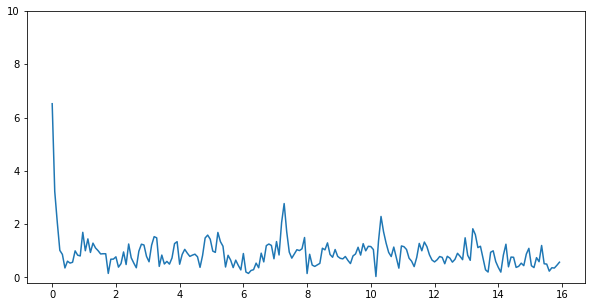

In [56]:
ens_mean = enkf.analysis.mean(axis=0)
rmse_enkf = RMSE(ens_mean, X_nature)

plt.figure(figsize=(10, 5))
plt.plot(ts[::8], rmse_enkf[::8])
plt.ylim([-0.2, 10])
print(rmse_enkf.mean())

# First moment

### Assimilate bias observations based on normality test

In [3]:
# first moment
ex_obs_dict = pickle.load(open('./data/obs_bias_005_040.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.05', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40'])

obsm=0.05, Mean RMSE=0.8642, Variance RMSE=0.3224,  Without spinup: Mean RMSE=0.8160, Variance RMSE=0.1528
obsm=0.15, Mean RMSE=0.9084, Variance RMSE=0.3172,  Without spinup: Mean RMSE=0.8624, Variance RMSE=0.1609
obsm=0.20, Mean RMSE=0.8994, Variance RMSE=0.3941,  Without spinup: Mean RMSE=0.8433, Variance RMSE=0.1717
obsm=0.25, Mean RMSE=0.9834, Variance RMSE=0.3792,  Without spinup: Mean RMSE=0.9289, Variance RMSE=0.1942
obsm=0.30, Mean RMSE=0.9683, Variance RMSE=0.3832,  Without spinup: Mean RMSE=0.9125, Variance RMSE=0.1791
obsm=0.35, Mean RMSE=0.9520, Variance RMSE=0.3935,  Without spinup: Mean RMSE=0.9032, Variance RMSE=0.2065
obsm=0.40, Mean RMSE=0.9612, Variance RMSE=0.4006,  Without spinup: Mean RMSE=0.9139, Variance RMSE=0.2457


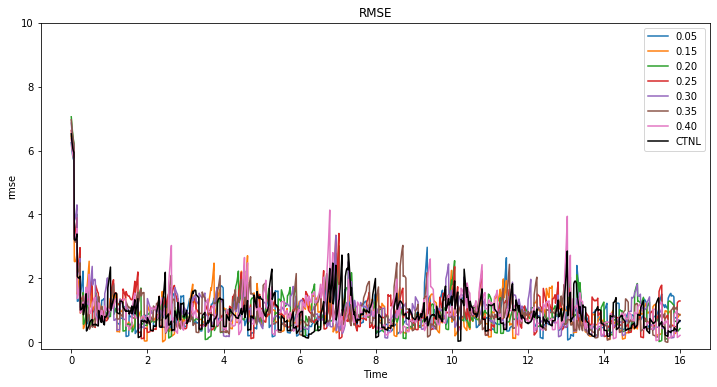

In [79]:
plt.figure(figsize=(12, 6))

mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

for obsm in ex_obs_dict.keys():
    obs = ex_obs_dict[obsm]

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }
    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=obsm)
    
plt.plot(ts, rmse_enkf, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse')
plt.ylim([-0.2, 10]);

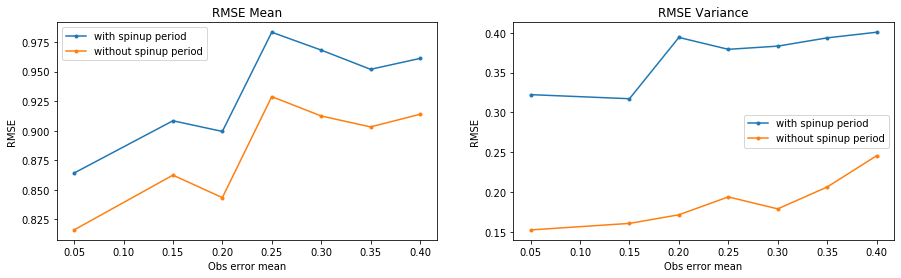

In [80]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_mean, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme bias observations

In [117]:
ex_obs_dict = pickle.load(open('./data/obs_bias_020_520.pickle', 'rb'))

obsm=0.20, Mean RMSE=0.9070, Variance RMSE=0.3440,  Without spinup: Mean RMSE=0.8612, Variance RMSE=0.1618
obsm=0.45, Mean RMSE=0.9998, Variance RMSE=0.4384,  Without spinup: Mean RMSE=0.9426, Variance RMSE=0.2483
obsm=0.70, Mean RMSE=1.1208, Variance RMSE=0.4615,  Without spinup: Mean RMSE=1.0689, Variance RMSE=0.3058
obsm=0.95, Mean RMSE=1.1571, Variance RMSE=0.5114,  Without spinup: Mean RMSE=1.1117, Variance RMSE=0.3156
obsm=1.20, Mean RMSE=1.1912, Variance RMSE=0.5965,  Without spinup: Mean RMSE=1.1430, Variance RMSE=0.4176
obsm=1.45, Mean RMSE=1.4204, Variance RMSE=0.5981,  Without spinup: Mean RMSE=1.3656, Variance RMSE=0.3865
obsm=1.70, Mean RMSE=1.6356, Variance RMSE=0.8029,  Without spinup: Mean RMSE=1.5728, Variance RMSE=0.5919
obsm=1.95, Mean RMSE=1.8724, Variance RMSE=1.1007,  Without spinup: Mean RMSE=1.7633, Variance RMSE=0.7021
obsm=2.20, Mean RMSE=1.9110, Variance RMSE=1.0148,  Without spinup: Mean RMSE=1.8308, Variance RMSE=0.7501
obsm=2.45, Mean RMSE=2.0350, Variance

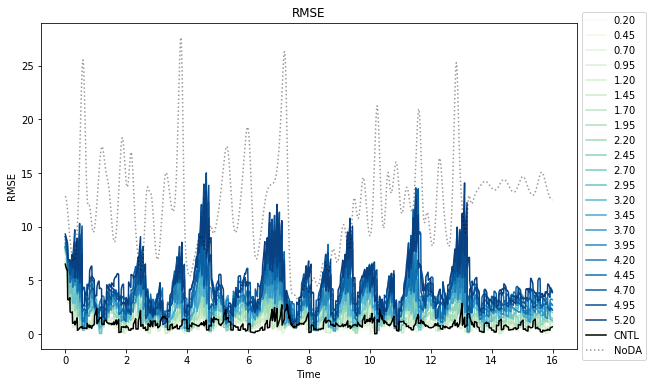

In [118]:
import matplotlib.cm as cm


mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))
colors = cm.GnBu(np.linspace(0, 1, len(ex_obs_dict.keys())))

for obsm, color in zip(ex_obs_dict.keys(), colors):
    obs = ex_obs_dict[obsm]

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())
    
    plt.plot(ts, rmse, color=color, label=obsm)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')

# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

Text(0, 0.5, 'RMSE')

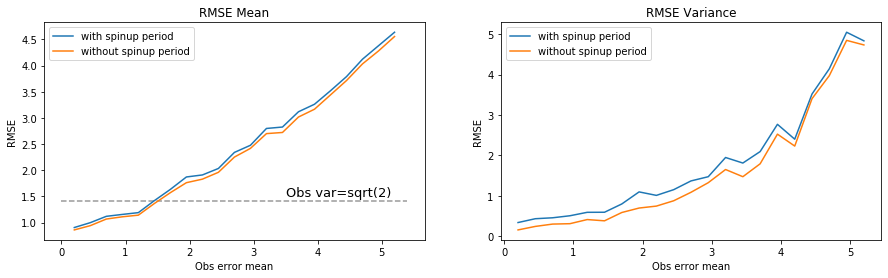

In [119]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')
axs[0].hlines(y=np.sqrt(2), xmin=0, xmax=5.4, ls='dashed', alpha=0.4)
axs[0].text(3.5, np.sqrt(2)+0.1, 'Obs var=sqrt(2)', fontsize=13)

axs[1].plot(ex_mean, var_rmse, label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE')

# Third moment

### Assimilate skew observation based on normality test

In [120]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.15', '0.45', '0.75', '1.05', '1.35'])

alpha=0.15, Mean RMSE=0.8842, Variance RMSE=0.3067,  Without spinup: Mean RMSE=0.8467, Variance RMSE=0.1517
alpha=0.45, Mean RMSE=0.8768, Variance RMSE=0.3619,  Without spinup: Mean RMSE=0.8154, Variance RMSE=0.1484
alpha=0.75, Mean RMSE=0.8905, Variance RMSE=0.4277,  Without spinup: Mean RMSE=0.8475, Variance RMSE=0.2560
alpha=1.05, Mean RMSE=0.8954, Variance RMSE=0.3132,  Without spinup: Mean RMSE=0.8555, Variance RMSE=0.1751
alpha=1.35, Mean RMSE=0.8230, Variance RMSE=0.3680,  Without spinup: Mean RMSE=0.7746, Variance RMSE=0.1707


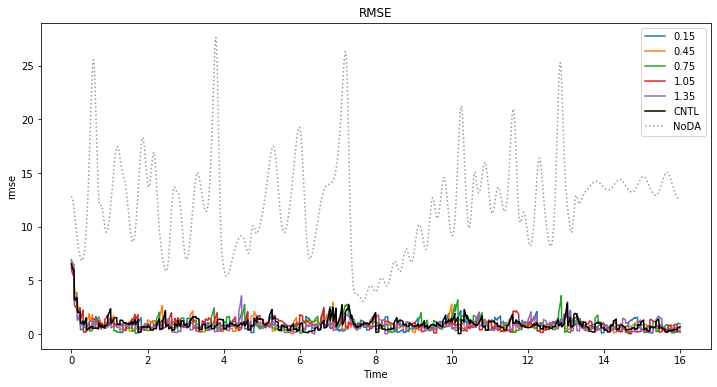

In [121]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

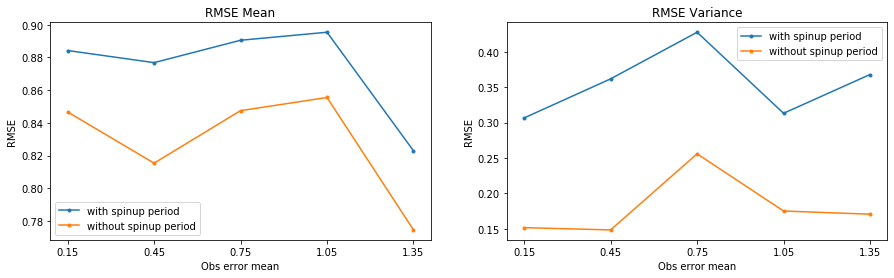

In [124]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme skewness

In [125]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

alpha=1.30, Mean RMSE=0.9567, Variance RMSE=0.4694,  Without spinup: Mean RMSE=0.8941, Variance RMSE=0.2513
alpha=1.55, Mean RMSE=0.8165, Variance RMSE=0.3393,  Without spinup: Mean RMSE=0.7671, Variance RMSE=0.1351
alpha=1.80, Mean RMSE=0.8542, Variance RMSE=0.3353,  Without spinup: Mean RMSE=0.8013, Variance RMSE=0.1635
alpha=2.05, Mean RMSE=0.8809, Variance RMSE=0.3723,  Without spinup: Mean RMSE=0.8305, Variance RMSE=0.1859
alpha=2.30, Mean RMSE=0.9130, Variance RMSE=0.4297,  Without spinup: Mean RMSE=0.8583, Variance RMSE=0.2053
alpha=2.55, Mean RMSE=0.8631, Variance RMSE=0.3535,  Without spinup: Mean RMSE=0.8274, Variance RMSE=0.2089
alpha=2.80, Mean RMSE=0.8281, Variance RMSE=0.2950,  Without spinup: Mean RMSE=0.7896, Variance RMSE=0.1435
alpha=3.05, Mean RMSE=0.9411, Variance RMSE=0.3087,  Without spinup: Mean RMSE=0.9046, Variance RMSE=0.1548
alpha=3.30, Mean RMSE=0.8676, Variance RMSE=0.3234,  Without spinup: Mean RMSE=0.8299, Variance RMSE=0.1760


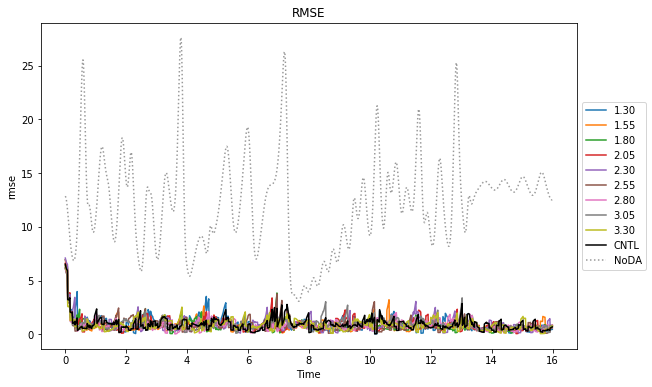

In [127]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

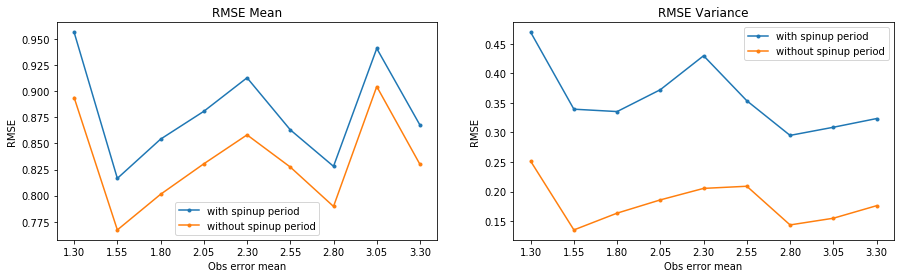

In [128]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Repeated assimilate skew observation based on normality test (repeat 10 times)

In [173]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_alpha = ex_obs_dict.keys()
ex_alpha = list(map(float, ex_alpha))
ex_alpha

[0.15, 0.45, 0.75, 1.05, 1.35]

In [174]:
from gen_skew_func import gen_skew_obs

rmse_dict = {}
for ex_a in ex_alpha:
    print(ex_a)
    rmse = np.zeros_like(ts)
    
    for _ in range(10):
        obs = gen_skew_obs(mean=0, var=2, alpha=ex_a, obs_intv=8)
        
        enkf_params = {
            'X_ens_ini': X_ens_ini, 
            'obs': obs, 
            'obs_interv': 8, 
            'R': R, 
            'H_func': None, 
            'alpha': 0.3,
            'inflat': 1.4
        }

        enkf = EnKF(lorenz63_fdm, dt)
        enkf.set_params(**enkf_params)
        enkf.cycle()
        ens_mean = enkf.analysis.mean(axis=0)
        rmse += RMSE(ens_mean, X_nature)

    rmse /= 10
    key = f'{ex_a:.2f}'
    rmse_dict[key] = rmse

0.15
0.45
0.75
1.05
1.35


alpha = 0.15, mean RMSE = 0.8931
alpha = 0.45, mean RMSE = 0.9005
alpha = 0.75, mean RMSE = 0.9011
alpha = 1.05, mean RMSE = 0.9026
alpha = 1.35, mean RMSE = 0.8917


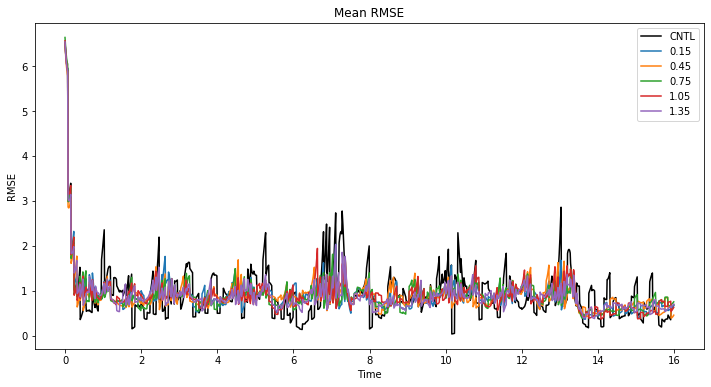

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(ts, rmse_enkf, 'k', label='CNTL')

for key, rmse in rmse_dict.items():
    print(f'alpha = {key}, mean RMSE = {rmse.mean():.4f}')
    plt.plot(ts, rmse, label=key)

plt.legend()
plt.title('Mean RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

### Repeated assimilate skew observations for more extreme alpha (repeat 10 times)

In [176]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_alpha = ex_obs_dict.keys()
ex_alpha = list(map(float, ex_alpha))
ex_alpha

[1.3, 1.55, 1.8, 2.05, 2.3, 2.55, 2.8, 3.05, 3.3]

In [177]:
from gen_skew_func import gen_skew_obs

rmse_dict = {}
for ex_a in ex_alpha:
    print(ex_a)
    rmse = np.zeros_like(ts)
    
    for _ in range(10):
        obs = gen_skew_obs(mean=0, var=2, alpha=ex_a, obs_intv=8)
        
        enkf_params = {
            'X_ens_ini': X_ens_ini, 
            'obs': obs, 
            'obs_interv': 8, 
            'R': R, 
            'H_func': None, 
            'alpha': 0.3,
            'inflat': 1.4
        }

        enkf = EnKF(lorenz63_fdm, dt)
        enkf.set_params(**enkf_params)
        enkf.cycle()
        ens_mean = enkf.analysis.mean(axis=0)
        rmse += RMSE(ens_mean, X_nature)

    rmse /= 10
    key = f'{ex_a:.2f}'
    rmse_dict[key] = rmse

1.3
1.55
1.8
2.05
2.3
2.55
2.8
3.05
3.3


alpha = 1.30, mean RMSE = 0.8975
alpha = 1.55, mean RMSE = 0.8875
alpha = 1.80, mean RMSE = 0.9019
alpha = 2.05, mean RMSE = 0.8989
alpha = 2.30, mean RMSE = 0.8870
alpha = 2.55, mean RMSE = 0.8900
alpha = 2.80, mean RMSE = 0.8882
alpha = 3.05, mean RMSE = 0.8915
alpha = 3.30, mean RMSE = 0.8933


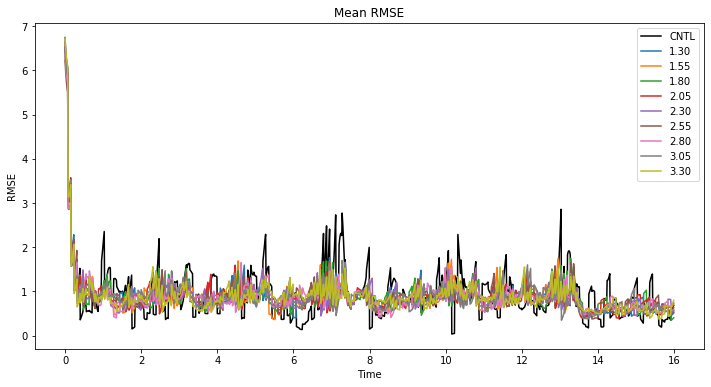

In [178]:
plt.figure(figsize=(12, 6))
plt.plot(ts, rmse_enkf, 'k', label='CNTL')

for key, rmse in rmse_dict.items():
    print(f'alpha = {key}, mean RMSE = {rmse.mean():.4f}')
    plt.plot(ts, rmse, label=key)

plt.legend()
plt.title('Mean RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

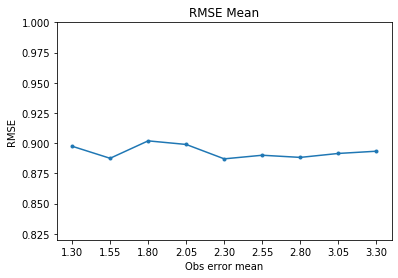

In [179]:
mean_rmse = []
for key, rmse in rmse_dict.items():
    mean_rmse.append(rmse.mean())


plt.plot(ex_alpha, mean_rmse, '.-')
plt.title('RMSE Mean')
plt.xticks(ex_alpha)
plt.xlabel('Obs error mean')
plt.ylabel('RMSE')
plt.ylim([0.82, 1]);

### Check the ratio of skew observation located bwteen -2*std ~ 2*std

In [180]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

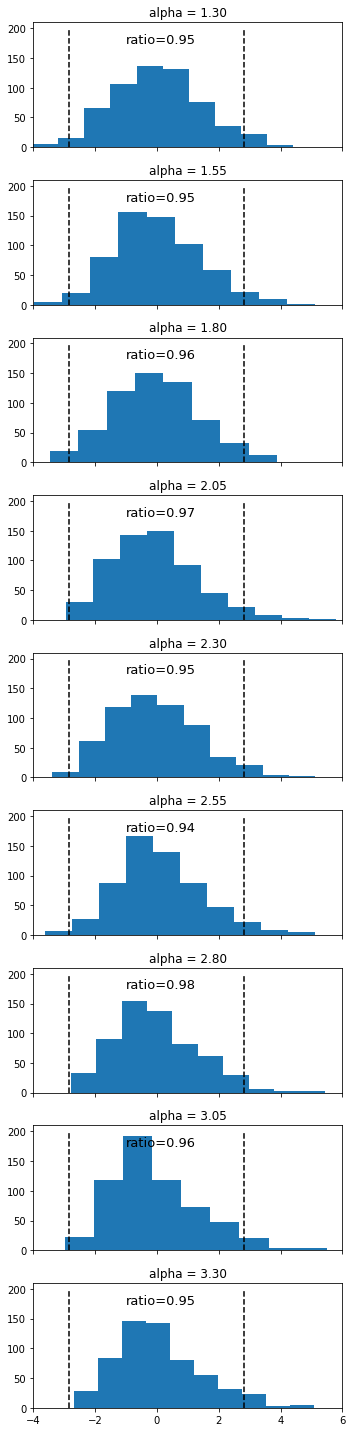

In [213]:
nrows = len(ex_obs_dict.keys())
fig, axs = plt.subplots(nrows=nrows, figsize=(5, 20), sharex=True)

for i, (key, obs) in enumerate(ex_obs_dict.items()):
    obserr = (obs - X_nature[:,::8]).ravel()
    axs[i].hist(obserr)
    
    std = np.sqrt(2)
    axs[i].vlines([2*std, -2*std], ymin=0, ymax=200, ls='dashed')
    axs[i].set_xlim([-4, 6])
    axs[i].set_title(f'alpha = {key}')
    
    total_size = obserr.size
    within_size = obserr[np.where((obserr <= 2*std) & (obserr >= -2*std))].size
    ratio = within_size / total_size
    axs[i].text(-1, 175, f'ratio={ratio:.2f}', fontsize=13)

plt.tight_layout()

# Fourth moment

### Assimilate kurtosis observation based on normality test

In [216]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_050_220.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.5', '0.6', '0.7', '0.8', '0.9', '1.2', '1.6', '1.8', '2.0', '2.2'])

delta=0.5, Mean RMSE=0.9233, Variance RMSE=0.4749,  Without spinup: Mean RMSE=0.8686, Variance RMSE=0.2838
delta=0.6, Mean RMSE=0.9108, Variance RMSE=0.3842,  Without spinup: Mean RMSE=0.8640, Variance RMSE=0.2241
delta=0.7, Mean RMSE=0.8728, Variance RMSE=0.3815,  Without spinup: Mean RMSE=0.8281, Variance RMSE=0.1794
delta=0.8, Mean RMSE=0.9052, Variance RMSE=0.3616,  Without spinup: Mean RMSE=0.8653, Variance RMSE=0.1815
delta=0.9, Mean RMSE=0.9042, Variance RMSE=0.3985,  Without spinup: Mean RMSE=0.8492, Variance RMSE=0.1780
delta=1.2, Mean RMSE=0.8991, Variance RMSE=0.3399,  Without spinup: Mean RMSE=0.8609, Variance RMSE=0.2087
delta=1.6, Mean RMSE=0.8433, Variance RMSE=0.3187,  Without spinup: Mean RMSE=0.7957, Variance RMSE=0.1484
delta=1.8, Mean RMSE=0.9513, Variance RMSE=0.3359,  Without spinup: Mean RMSE=0.9061, Variance RMSE=0.1844
delta=2.0, Mean RMSE=0.8653, Variance RMSE=0.3100,  Without spinup: Mean RMSE=0.8213, Variance RMSE=0.1572
delta=2.2, Mean RMSE=0.8812, Variance

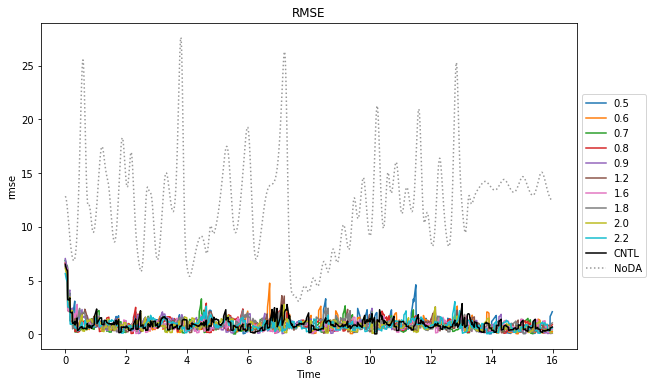

In [218]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

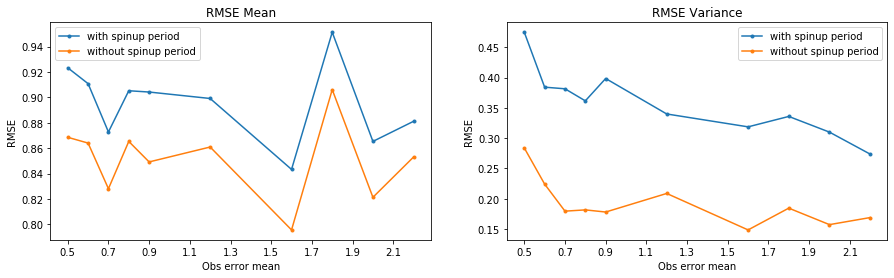

In [225]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_delta, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_delta, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

(-20, 20)

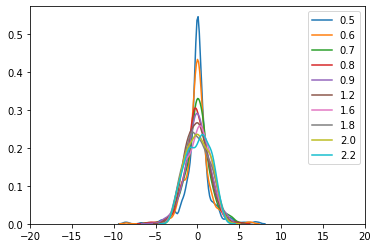

In [224]:
import seaborn as sns

fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20])

### Assimilate kurtosis observation with more extreme delta

In [228]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_010_340.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.1', '0.2', '0.3', '0.4', '2.5', '2.8', '3.1', '3.4'])

delta=0.1, Mean RMSE=0.6634, Variance RMSE=0.5508,  Without spinup: Mean RMSE=0.6133, Variance RMSE=0.3666
delta=0.2, Mean RMSE=0.7960, Variance RMSE=0.7412,  Without spinup: Mean RMSE=0.7570, Variance RMSE=0.5859
delta=0.3, Mean RMSE=0.8274, Variance RMSE=0.3839,  Without spinup: Mean RMSE=0.7811, Variance RMSE=0.2198
delta=0.4, Mean RMSE=0.8134, Variance RMSE=0.3817,  Without spinup: Mean RMSE=0.7578, Variance RMSE=0.1912
delta=2.5, Mean RMSE=0.8767, Variance RMSE=0.3606,  Without spinup: Mean RMSE=0.8325, Variance RMSE=0.1905
delta=2.8, Mean RMSE=0.8791, Variance RMSE=0.2967,  Without spinup: Mean RMSE=0.8468, Variance RMSE=0.1969
delta=3.1, Mean RMSE=0.8707, Variance RMSE=0.2509,  Without spinup: Mean RMSE=0.8292, Variance RMSE=0.1251
delta=3.4, Mean RMSE=0.9085, Variance RMSE=0.2982,  Without spinup: Mean RMSE=0.8682, Variance RMSE=0.1760


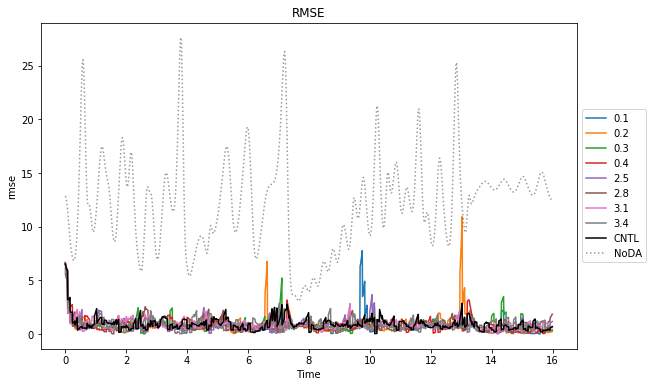

In [229]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

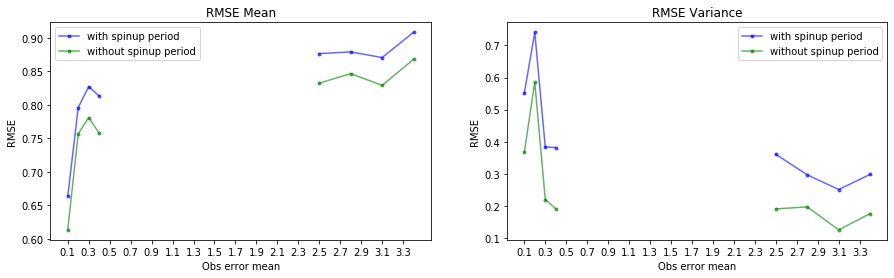

In [241]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta[:4], mean_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[0].plot(ex_delta[4:], mean_rmse[4:], 'b.-', alpha=0.6)
axs[0].plot(ex_delta[:4], mean_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[0].plot(ex_delta[4:], mean_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta[:4], var_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[1].plot(ex_delta[4:], var_rmse[4:], 'b.-', alpha=0.6)
axs[1].plot(ex_delta[:4], var_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[1].plot(ex_delta[4:], var_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

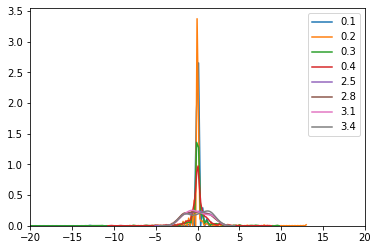

In [232]:
fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20]);